In [1]:
# import numba as nb
import numpy as np
import pandas as pd
import scipy.stats as stats
import chaospy as cp
# from pathlib import Path
# from multiprocessing import Pool
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# from temfpy.uncertainty_quantification import eoq_model

# Harris Model from [Sensitivity analysis: A review of recent advances](https://www.sciencedirect.com/science/article/abs/pii/S0377221715005469)

Economic order quantity model, or Harris model, was developed by [Harris (1990)](https://doi.org/10.1287/opre.38.6.947), to solve the problem of firms determining the ideal order size for one year, considering inventory costs and ordering costs.

The model takes four variables, and determins the total ordering cost $T$:

$$T = \frac{1}{2\cdot 12R\cdot M}(CX + S) +\frac{S}{X} + C$$

- $M$ denotes the number of goods needed per month
- $C$ denotes the unit price of the good
- $X$ denotes the order size
- $S$ denotes the cost of placing an order (setup cost)

and $R$ is the interest and depreciation cost per month ($R=10$ in Harris (1990)), which we treat as an exogenous parameter. 

Therefore, $T$ is an function of $X$, and we can calculate the optimal order size $X^*$ by solving:

$$\begin{aligned}\min_{X} && T &= \frac{1}{2\cdot 12R\cdot M}(CX + S) +\frac{S}{X} + C \\
&& \frac{\partial T}{\partial X} &= \frac{C}{24R\cdot M} - \frac{S}{X^2} \overset{!}{=} 0 \\
&& X^* &= \sqrt{\frac{24R\cdot MS}{C}}\end{aligned}$$

$X^*$ is called economic order quantity(EOQ).

In sensitivity analysis, $X^*$ is denoted as $y$, the model output, and the model inputs are $M$, $C$ and $S$, denoted as $\mathbf{x}=(x_1,x_2,x_3)'$:

$$y = \sqrt{\frac{24r\cdot x_1 x_3}{x_2}}$$

We are interested in how $y$ changes depending on each $x_i$, in other words, the sensitivity of $y$ with regard to $x_i$.

## EOQ Function

EOQ from [temfpy/uncertainty_quantification.py](https://github.com/OpenSourceEconomics/temfpy/blob/master/temfpy/uncertainty_quantification.py)

In [2]:
def eoq_model(x, r=0.1):
    r"""Economic order quantity model.
    This function computes the optimal economic order quantity (EOQ) based on the model presented in
    [H1990]_. The EOQ minimizes the holding costs as well as ordering costs. The core parameters of
    the model are the units per months `x[0]`, the unit price of items in stock `x[1]`,
    and the setup costs of an order `x[2]`. The annual interest rate `r` is treated as an
    additional parameter.
    Parameters
    ----------
    x : array_like
        Core parameters of the model
    r : float, optional
        Annual interest rate
    Returns
    -------
    float
        Optimal order quantity
    Notes
    -----
    A historical perspective on the model is provided by [E1990]_. A brief description with the core
    equations is available in [W2020]_.
    References
    ----------
    .. [H1990] Harris, F. W. (1990).
        How many parts to make at once.
        Operations Research, 38(6), 947–950.
    .. [E1990] Erlenkotter, D. (1990).
        Ford Whitman Harris and the economic order quantity model.
        Operations Research, 38(6), 937–946.
    .. [W2020] Economic order quantity. (2020, April 3). In Wikipedia.
        Retrieved from
        `https://en.wikipedia.org/w/index.php\
        ?title=Economic_order_quantity&oldid=948881557 <https://en.wikipedia.org/w/index.php
        ?title=Economic_order_quantity&oldid=948881557>`_
    Examples
    --------
    >>> x = [1, 2, 3]
    >>> y = eoq_model(x, r=0.1)
    >>> np.testing.assert_almost_equal(y, 18.973665961010276)
    """

    m, c, s = x
    y = np.sqrt((24 * m * s) / (r * c))

    return y

## Data Generation

In [3]:
# Set flags

seed = 123
n = 10000

x_min_multiplier = 0.9
x_max_multiplier = 1.1
m_0 = 1230
c_0 = 0.0135
s_0 = 2.15

### No Monte Carlo

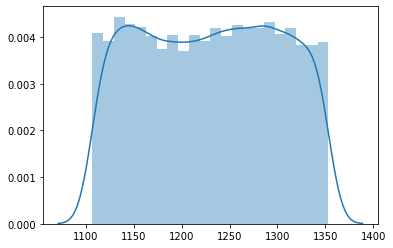

In [7]:
np.random.seed(seed)
m = np.random.uniform(low=x_min_multiplier*m_0,
                      high=x_max_multiplier*m_0,
                      size=n)
c = np.random.uniform(low=x_min_multiplier*c_0,
                      high=x_max_multiplier*c_0,
                      size=n)
s = np.random.uniform(low=x_min_multiplier*s_0,
                      high=x_max_multiplier*s_0,
                      size=n)
plt.clf()
sns.distplot(m)

### Monte Carlo with `rvs`

In [8]:
np.random.seed(seed)
m = stats.uniform(x_min_multiplier*m_0,
                    x_max_multiplier*m_0).rvs(10000)
c = stats.uniform(x_min_multiplier*c_0,
                    x_max_multiplier*c_0).rvs(10000)
s = stats.uniform(x_min_multiplier*s_0,
                    x_max_multiplier*s_0).rvs(10000)

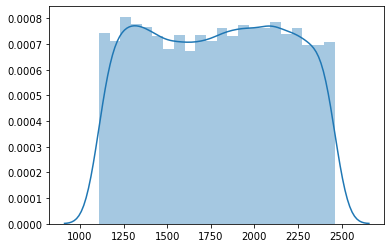

In [9]:
plt.clf()
sns.distplot(m)

### Monte Carlo with Chaospy (Closer numbers to Borgonovoa & Plischkeb (2016))

In [11]:
sample_rule = "random"

In [12]:
np.random.seed(seed)
m = cp.Uniform(x_min_multiplier*m_0,
               x_max_multiplier*m_0).sample(n, rule=sample_rule)
c = cp.Uniform(x_min_multiplier*c_0,
               x_max_multiplier*c_0).sample(n, rule=sample_rule)
s = cp.Uniform(x_min_multiplier*s_0,
               x_max_multiplier*s_0).sample(n, rule=sample_rule)

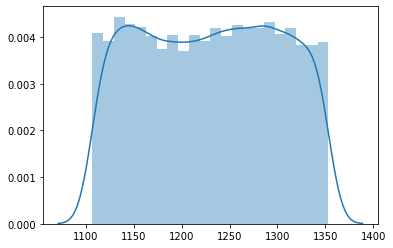

In [13]:
plt.clf()
sns.distplot(m)

In [14]:
x = np.array([m, c, s])
x

array([[1.27833142e+03, 1.17739028e+03, 1.16280546e+03, ...,
        1.34934566e+03, 1.16128288e+03, 1.25787110e+03],
       [1.39404844e-02, 1.44174233e-02, 1.43738668e-02, ...,
        1.33516980e-02, 1.28980980e-02, 1.29058299e-02],
       [1.97218534e+00, 2.18619070e+00, 2.13828332e+00, ...,
        1.98743053e+00, 2.29921719e+00, 2.15418739e+00]])

In [15]:
y = eoq_model(x)

<Figure size 432x288 with 0 Axes>

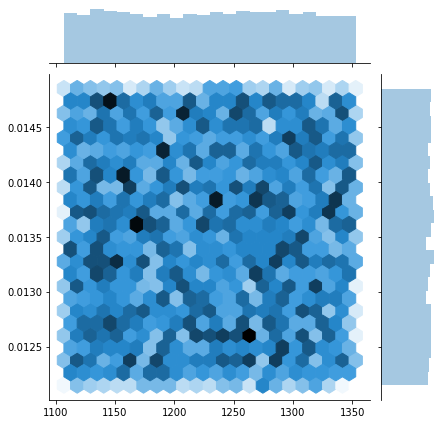

In [57]:
plt.clf()
sns.jointplot(x=x[0], y=x[1], kind="hex")

<Figure size 432x288 with 0 Axes>

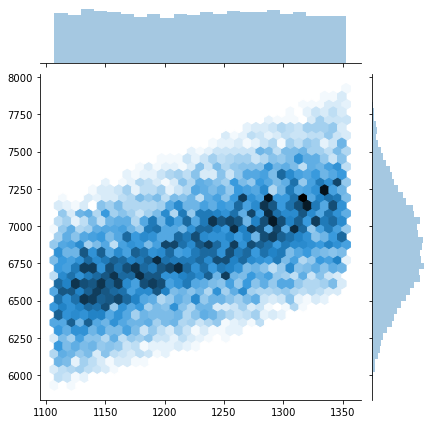

In [101]:
plt.clf()
sns.jointplot(x=x[0], y=y, kind="hex")

# Correlated Sampling with Harris Model

## Generation

- `.Nataf(dist, R, ordering=None)`
- `.TCopula(dist, df, R)`

In [ ]:
m_dist = cp.Uniform(x_min_multiplier*m_0, x_max_multiplier*m_0)
c_dist = cp.Uniform(x_min_multiplier*c_0, x_max_multiplier*c_0)
s_dist = cp.Uniform(x_min_multiplier*s_0, x_max_multiplier*s_0)

In [90]:
R = [
     [1, 0.5, 0.4],
     [0.5, 1, 0.7],
     [0.4, 0.7, 1]
    ]

In [91]:
x_dist = cp.J(m_dist, c_dist, s_dist)
x_copula = cp.Nataf(x_dist, R)

In [92]:
np.random.seed(seed)
x_copula_sample = x_copula.sample(n)

In [93]:
y_copula = eoq_model(x_copula_sample)

## X's

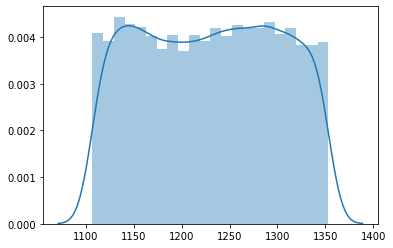

In [94]:
plt.clf()
sns.distplot(x_copula_sample[0])

<Figure size 432x288 with 0 Axes>

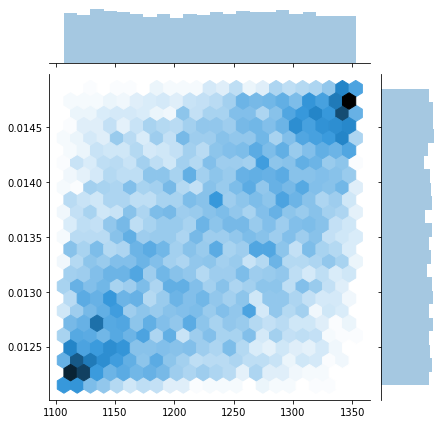

In [95]:
plt.clf()
sns.jointplot(x=x_copula_sample[0],
              y=x_copula_sample[1],
              kind="hex")

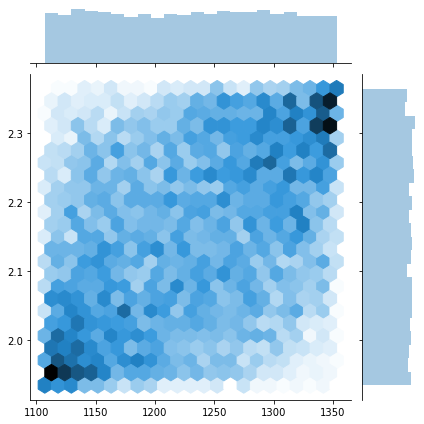

In [96]:
sns.jointplot(x=x_copula_sample[0],
              y=x_copula_sample[2],
              kind="hex")

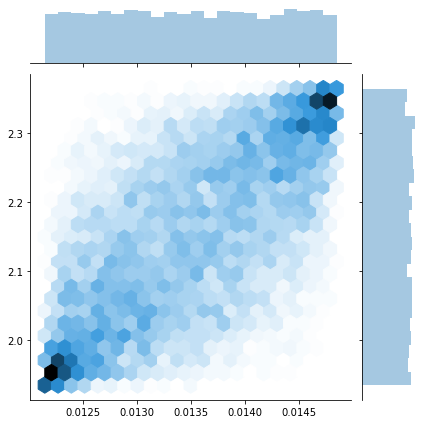

In [97]:
sns.jointplot(x=x_copula_sample[1],
              y=x_copula_sample[2],
              kind="hex")

## X & y

<Figure size 432x288 with 0 Axes>

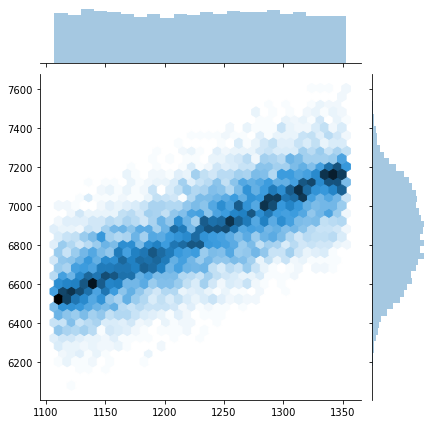

In [98]:
plt.clf()
sns.jointplot(x=x_copula_sample[0],
              y=y_copula,
              kind="hex")

<Figure size 432x288 with 0 Axes>

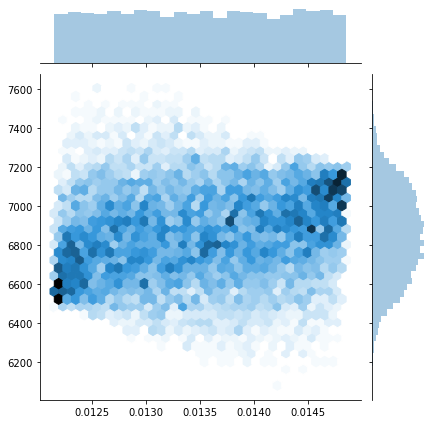

In [99]:
plt.clf()
sns.jointplot(x=x_copula_sample[1],
              y=y_copula,
              kind="hex")

<Figure size 432x288 with 0 Axes>

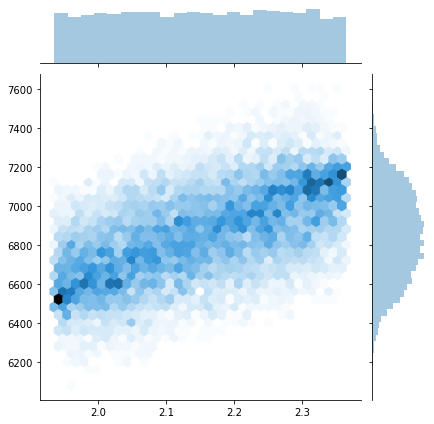

In [100]:
plt.clf()
sns.jointplot(x=x_copula_sample[2],
              y=y_copula,
              kind="hex")

# Replicating: [Introducing Copula in Monte Carlo Simulation](https://towardsdatascience.com/introducing-copula-in-monte-carlo-simulation-9ed1fe9f905)

## Random Variable Transformation

In [26]:
# Generate Monte Carlo sample

x = stats.uniform(0, 1).rvs(10000)

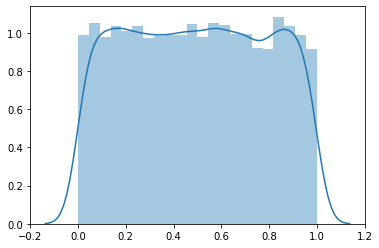

In [27]:
plt.clf()
sns.distplot(x)

In [28]:
norm = stats.distributions.norm()
x_trans = norm.ppf(x)

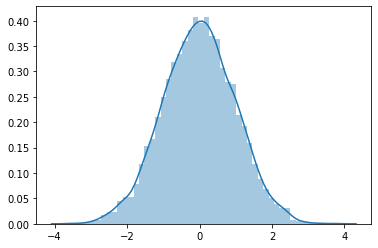

In [29]:
plt.clf()
sns.distplot(x_trans)

<Figure size 432x288 with 0 Axes>

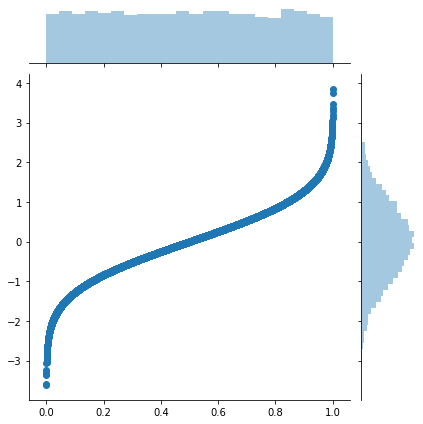

In [30]:
plt.clf()
sns.jointplot(x=x, y=x_trans)

## Gaussian Copula — Adding Variable Correlations

In [54]:
mvnorm = stats.multivariate_normal([0, 0], [[1., 0.5], [0.5, 1.]])
x = mvnorm.rvs((10000,))

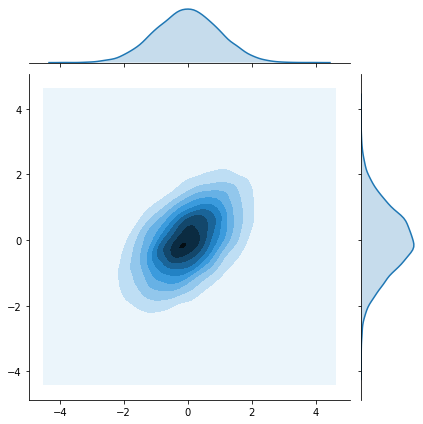

In [63]:
sns.jointplot(x=x[:,0], y=x[:,1], kind="kde")

In [64]:
norm = stats.norm([0],[1])
x_unif = norm.cdf(x)

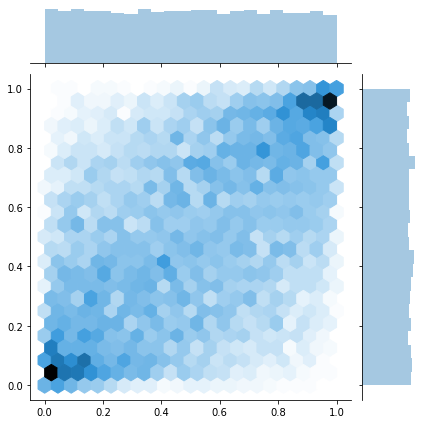

In [65]:
plt.clf()
sns.jointplot(x=x_unif[:,0], y=x_unif[:,1], kind="hex")

In [66]:
x1_tri  = stats.triang.ppf(x_unif[:, 0],  c=0.158 , loc=36, scale=21)
x2_norm =stats.norm(525, 112).ppf(x_unif[:, 1])

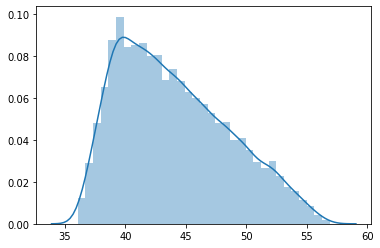

In [67]:
plt.clf()
sns.distplot(x1_tri)

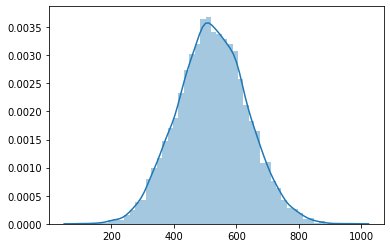

In [68]:
plt.clf()
sns.distplot(x2_norm)

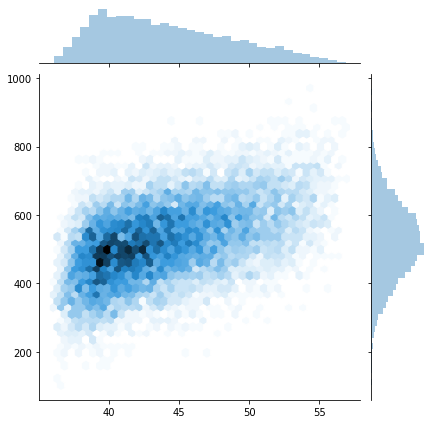

In [70]:
plt.clf()
sns.jointplot(x=x1_tri, y=x2_norm, kind="hex")

## Probabilistic Estimation of HCIIP

### No Variable Correlation Case

In [71]:
# HCIIP = GRV*NTG*POR*SHC/FVF

means = [0.]*5
cov = [[1., 0., 0., 0., 0.],
[0., 1., 0., 0., 0.],
[0., 0., 1., 0., 0.],
[0., 0., 0., 1., 0.],
[0., 0., 0., 0., 1.]]

mvnorm_std = stats.multivariate_normal(means,cov)
x = mvnorm_std.rvs(10000,random_state=42)
norm_std = stats.norm()
x_unif = norm_std.cdf(x)

#create individual distr.
grv = stats.triang(c=0.1 , loc=10000, scale=300).ppf(x_unif[:, 0])
ntg = stats.triang(c=0.2 , loc=0.5, scale=0.5).ppf(x_unif[:, 1])
phi = stats.truncnorm(-2*1.96,1.96,0.2,0.05).ppf(x_unif[:, 2])
shc = stats.norm(0.6,0.05).ppf(x_unif[:, 3])
fvf= stats.truncnorm(-1.96,2*1.96,1.3,0.1).ppf(x_unif[:, 4])

stoiip = 7758*grv*ntg*phi*shc/fvf/1e6

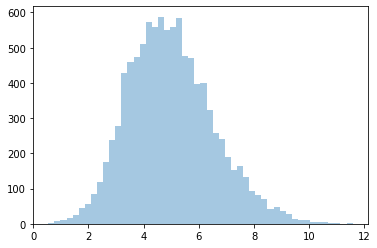

In [79]:
plt.clf()
sns.distplot(stoiip, kde=False)

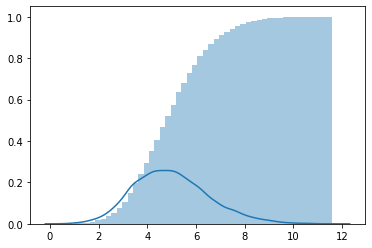

In [85]:
plt.clf()
sns.distplot(stoiip, hist_kws=dict(cumulative=True))

### Variable Correlation Case

In [86]:
means = [0.]*5

cov = [[1., 0., 0., 0., 0.],
[0., 1., 0.7, 0.6, 0.],
[0., 0.7, 1., 0.8, 0.],
[0., 0.6, 0.8, 1., 0.],
[0., 0., 0., 0., 1.]]

mvnorm_std = stats.multivariate_normal(means,cov)
x = mvnorm_std.rvs(10000,random_state=42)
norm_std = stats.norm()
x_unif = norm_std.cdf(x)

#create individual distr.
grv = stats.triang(c=0.1 , loc=10000, scale=300).ppf(x_unif[:, 0])
ntg = stats.triang(c=0.2 , loc=0.5, scale=0.5).ppf(x_unif[:, 1])
phi = stats.truncnorm(-2*1.96,1.96,0.2,0.05).ppf(x_unif[:, 2])
shc = stats.norm(0.6,0.05).ppf(x_unif[:, 3])
fvf= stats.truncnorm(-1.96,2*1.96,1.3,0.1).ppf(x_unif[:, 4])

stoiip = 7758*grv*ntg*phi*shc/fvf/1e6

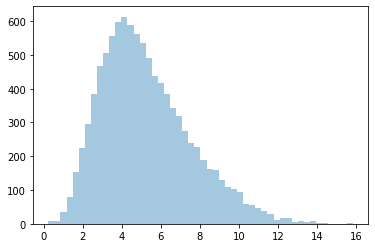

In [87]:
plt.clf()
sns.distplot(stoiip, kde=False)

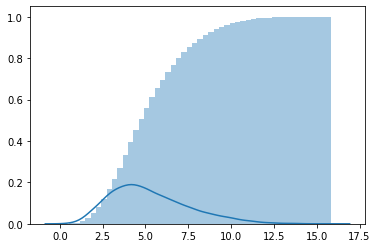

In [88]:
plt.clf()
sns.distplot(stoiip, hist_kws=dict(cumulative=True))

# Testing ChaosPy: [Distributions — ChaosPy documentation](https://chaospy.readthedocs.io/en/master/distributions/index.html)

In [90]:
# to create a Gaussian random variable:
distribution = cp.Normal(mu=2, sigma=2)

In [91]:
# to create values from the probability density function:
t = np.linspace(-3, 3, 9)
distribution.pdf(t).round(3)

array([0.009, 0.021, 0.043, 0.078, 0.121, 0.164, 0.193, 0.198, 0.176])

In [93]:
# create values from the cumulative distribution function:
distribution.cdf(t).round(3)

array([0.006, 0.017, 0.04 , 0.085, 0.159, 0.266, 0.401, 0.55 , 0.691])

In [94]:
# To be able to perform any Monte Carlo method,
# each distribution contains random number generator:
distribution.sample(6).round(4)

array([3.1908, 1.5794, 2.1213, 0.3613, 2.2973, 2.5376])

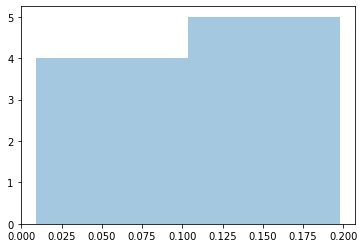

In [101]:
plt.clf()
sns.distplot(distribution.pdf(t).round(3), kde=False)

In [103]:
# to create low-discrepancy Hammersley sequences
# samples combined with antithetic variates:
distribution.sample(size=6, rule="halton", antithetic=True).round(4)

array([ 3.349 ,  0.651 , -0.3007,  4.3007,  2.6373,  1.3627])

## Moments: [Descriptive Statistics — ChaosPy documentation](https://chaospy.readthedocs.io/en/master/descriptives.html#descriptives)

In [104]:
# the variance is defined as follows:
distribution.mom(2) - distribution.mom(1)**2

4.0

In [108]:
# or:
cp.Var(distribution)

array(4.)

## Seeding

In [112]:
np.random.seed(1234)
distribution.sample(5).round(4)

array([0.2554, 2.622 , 1.6865, 3.5808, 3.5442])

In [115]:
distribution.sample(5).round(4)

array([ 2.308 ,  2.0155, -2.4076,  3.4964,  4.3766])

## [Copulas — ChaosPy documentation](https://chaospy.readthedocs.io/en/master/distributions/copulas.html)

In [30]:
np.random.seed(1234)
dist = cp.Iid(cp.Uniform(), 2)
copula = cp.Gumbel(dist, theta=1.5)

In [34]:
dist

Iid(Uniform(lower=0, upper=1), 2)

In [31]:
copula

Gumbel(Iid(Uniform(lower=0, upper=1), 2), theta=1.5)

In [32]:
np.random.seed(1234)
sample = copula.sample(10000)

<Figure size 432x288 with 0 Axes>

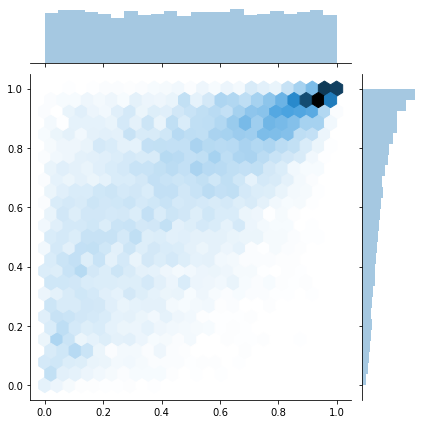

In [33]:
plt.clf()
sns.jointplot(x=sample[0], y=sample[1], kind="hex")

ok, what now…